<a href="https://colab.research.google.com/github/chalos18/COSC-Studies/blob/main/DATA301_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project

In this study I will answer the question: Which pairs of books are most strongly and frequently read together based on users' reading patterns?

Method: Market basket analysis (MBA) with the Apriori algorithm to identify pairs of books with the highest interest across different genres. By analysing these book pairings, we can develop a recommendation system that suggests books based on shared reading patterns.

In [ ]:
# Example (interaction data)

{
  "user_id": "8842281e1d1347389f2ab93d60773d4d",
  "book_id": "130580",
  "review_id": "330f9c153c8d3347eb914c06b89c94da",
  "rating": 4,
  "date_added": "Mon Aug 01 13:41:57 -0700 2011",
  "date_updated": "Mon Aug 01 13:42:41 -0700 2011",
  "read_at": "Fri Jan 01 00:00:00 -0800 1988",
  "started_at": ""
}

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'book_id': '130580',
 'review_id': '330f9c153c8d3347eb914c06b89c94da',
 'rating': 4,
 'date_added': 'Mon Aug 01 13:41:57 -0700 2011',
 'date_updated': 'Mon Aug 01 13:42:41 -0700 2011',
 'read_at': 'Fri Jan 01 00:00:00 -0800 1988',
 'started_at': ''}

# Pre-requisites

Import the below to be able to run the project. A description of why each is used is provided, as per the Final Report.

In [ ]:
# Used for better handling of files/chunks and for visualising progress

import os # Listing making and checking directories
import shutil # If path exists, use this to remove it
import pickle # Saving intermediate locations when processing/running algorithms on chunks
from glob import glob # Useful for pathname patterns for files
import json # Used during the loading of the data
import gzip # Used during the loading of the data

from tqdm import tqdm # Progress bar decorator for easier tracking of processes
import urllib.request # For downloading the dataset

# Used for my algorithms' logic

from functools import partial # Useful for binding arguments for Dask to call later
from collections import Counter # Counting item frequencies in a more efficient manner than some of my previous implementations of a-priori

import pandas as pd # Creating dataframes to help with chunking
import pyarrow as pa # Creating tables to help with chunking
import pyarrow.parquet as pq # Writing tables to help with chunking

import dask.dataframe as dd # Dask Dataframe for parallel processing
import dask.bag as db # Dask Bag for parallel processing

import numpy as np # Useful for combining and deduplicating sets of book ids

import time # For timing calculations for my final results

# Loading the data
The chosen datasets are in JSON so I have to load it into a more manageable and reliable format first.

I will use the Goodreads dataset late 2017 and updated at the start of 2025 from goodreads.com (see https://mcauleylab.ucsd.edu:8443/public_datasets/gdrive/goodreads/).

Datasets:


*   Goodreads Reviews: Complete book reviews (~15m multilingual reviews about ~2m books and 465k users) 5.0 GB
*   Goodreads Books: About 2.3m books 1.9GB


In [ ]:
filename = 'goodreads_reviews_dedup.json.gz'
urllib.request.urlretrieve('https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/goodreads_reviews_dedup.json.gz', filename)
print("Downloaded:", filename)

Downloaded: goodreads_reviews_dedup.json.gz


As the parquet file is quite large, I decided to load it and process it in chunks.

In [ ]:
input_file = 'goodreads_reviews_dedup.json.gz'
output_dir = 'goodreads_user_book_parquet_chunks'

# If the path exists, remove it and recreate it
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

os.makedirs(output_dir)
print(f"Output dir is ready: {output_dir}, contains {len(os.listdir(output_dir))} files")

# Loading the Parquet into chunks to avoid running out of memory
chunk_size = 100000
buffer = []
part = 0

with gzip.open(input_file, 'rt', encoding='utf-8') as f:
    for i, line in tqdm(enumerate(f)):
        data = json.loads(line)

        # Filter the dataset to only contain the desired variables ...
        # ... this also reduces the data in size which is helpful for later

        buffer.append({
            'user_id': data.get('user_id'),
            'book_id': data.get('book_id')
        })

        # This writes to parquet once the buffer reaches the chosen chunk
        if len(buffer) >= chunk_size:
            df = pd.DataFrame(buffer)
            table = pa.Table.from_pandas(df)
            pq.write_table(table, f"{output_dir}/part_{part:05d}.parquet")
            part += 1
            # reset buffer for next iteration
            buffer = []

if buffer:
    df = pd.DataFrame(buffer)
    table = pa.Table.from_pandas(df)
    pq.write_table(table, f"{output_dir}/part_{part:05d}.parquet")

print(f"{part} Parquet chunks saved in '{output_dir}'")
print(f"Output dir: {output_dir}, contains {len(os.listdir(output_dir))} files")

Output dir is ready: goodreads_user_book_parquet_chunks, contains 0 files


15739967it [06:03, 43269.58it/s]

 157 Parquet chunks saved in 'goodreads_user_book_parquet_chunks'
Output dir: goodreads_user_book_parquet_chunks, contains 158 files


# Group books into baskets
Each user will be represented as a "basket" containing the books they have read. These baskets will then be used to generate individual book frequency counts (step one of the Apriori algorithm), which will help identify frequently read books.




In [ ]:
# The below is for step 1 of the Apriori algorithm and for some validation
# this helped me with some early checks that my data was setup correctly

# Load the parquet files from the directory
ddf = dd.read_parquet(output_dir)

# Get the number of unique user_ids in the dataframe to compare to the number of baskets
unique_users = ddf['user_id'].nunique().compute()
print(f"Unique users: {unique_users}")

# Group by user_id and collect all book_ids into a list (the basket)
user_baskets = ddf.groupby('user_id')['book_id'].apply(list, meta=('book_id', 'object'))

# print("Persisting user baskets...")
# user_baskets = user_baskets.persist()
# print("User baskets persisted.")

basket_bag = user_baskets.to_bag()

N = basket_bag.count().compute()
print("Number of baskets:", N)

# Number of unique users should match up to the number of baskets
assert(unique_users == N)

# Show the first 3 baskets (each is a list of book_ids)
print(basket_bag.take(3))

Unique users: 465323
Number of baskets: 465323
(['18393643', '8933944', '13410155'], ['320730', '45107', '301082'], ['13586707', '30253864', '22822858', '961241', '10310', '18050735', '16071764'])


# Run step 1 of the Apriori algorithm

> Map each line of the dask bag and then perform a book count on the entire bag. e. `.flatten()` take individual books and puts them in a flat collection `[['A', 'B'], ['A', 'C']]` would become `['A', 'B', 'A', 'C']`. This allows `.frequencies()` to count each unique element and return a structure such as the following `[('11870085', 127), ('2767052', 90), ('7260188', 73), ...]`




In [ ]:
support_n = 100

In [ ]:
def a_priori_step1(file_bag):
  book_count = file_bag.flatten().frequencies()
  return book_count

# filter by the support number
book_count = a_priori_step1(basket_bag).filter(lambda kv: kv[1]>=support_n)
book_count_dict = dict(book_count)

In [ ]:
print(book_count.topk(3, key=1).compute())
print(len(book_count_dict))

[('11870085', 20756), ('2767052', 18617), ('7260188', 13536)]
18640


# Run Apriori algorithm on each parquet chunk

In [ ]:
def freq_pairs_gen(line, filtered_book_count):
    result = []
    for i in range(len(line)):
        for j in range(i + 1, len(line)):
            if line[i] in filtered_book_count and line[j] in filtered_book_count:
                result.append(tuple(sorted((line[i], line[j]))))
    return result

def a_priori(file_bag, support=100):
    # Get counts for each book and filter them based on the support number
    book_count = file_bag.flatten().frequencies().compute()
    filtered_book_count = {book[0] for book in book_count if book[1] >= support}

    # Map the freq_pairs_gen function on the bag
    mapped_func = partial(freq_pairs_gen, filtered_book_count=filtered_book_count)
    book_pair_count = file_bag.map(mapped_func).flatten()

    # Calculate the book pair counts
    book_frequencies = book_pair_count.frequencies().compute()
    return Counter(dict(book_frequencies))

In [ ]:
output_dir = 'goodreads_user_book_parquet_chunks'
intermediate_dir = 'intermediate_book_pair_counts'
os.makedirs(intermediate_dir, exist_ok=True)

chunks = sorted(glob(f"{output_dir}/part_*.parquet"))

# Go through each chunk, read the parquet, group user id and book id and get the book pair counts
for i, file in tqdm(enumerate(chunks), total=len(chunks)):
    ddf = dd.read_parquet(file)
    user_baskets = ddf.groupby('user_id')['book_id'].apply(list, meta=('book_id', 'object'))
    basket_bag = user_baskets.to_bag()
    book_pair_counts = a_priori(basket_bag, support=support_n)

    with open(f"{intermediate_dir}/pairs_{i:05d}.pkl", "wb") as f:
        pickle.dump(book_pair_counts, f)

100%|██████████| 158/158 [18:28<00:00,  7.02s/it]


# Agreggate all pair counts from all the parquet chunks to get the frequent book pairs

In [ ]:
book_pair_counts = Counter()

chunk_files = sorted(glob(f"{intermediate_dir}/pairs_*.pkl"))

# Aggregate book pair counts from all the chunks in the intermediate directory
for file in tqdm((chunk_files), total=len(chunk_files)):
    with open(file, "rb") as f:
        counts = pickle.load(f)
        book_pair_counts.update(counts)

book_pair_bag = db.from_sequence(book_pair_counts.items())

100%|██████████| 158/158 [00:00<00:00, 21589.13it/s]


In [ ]:
print(f"Total number of frequent book pairs: {len(book_pair_counts)}")
print(f"{book_pair_bag.topk(3, key=lambda x: x[1]).compute()}")

Total number of frequent book pairs: 1061
[(('11870085', '2767052'), 2019), (('2767052', '7260188'), 1074), (('2767052', '6148028'), 897)]


# Calculate confidence scores



In [ ]:
def calculate_confidence(book_pair_counts, book_count_dict):
    confidences = []
    for (book1, book2), pair_count in book_pair_counts.items():
        count_book_1 = book_count_dict.get(book1, 0)

        # Confidence, conf(I -> j) = support(I u j) / support(I)
        if count_book_1 > 0:
            conf = pair_count / count_book_1
            confidences.append((book1, book2, conf))

    return pd.DataFrame(confidences, columns=["book1", "book2", "confidence"])

confidence_df = calculate_confidence(book_pair_counts, book_count_dict)

In [ ]:
print(confidence_df.nlargest(5, 'confidence'))

       book1    book2  confidence
0   11870085  2767052    0.097273
13   6148028  7260188    0.064684
5    2767052  7260188    0.057689
27   1162543    41865    0.056890
26   1162543    49041    0.052457


In [ ]:
def calculate_interest(conf_df, book_count_dict, total_transactions):
    interest = []

    # Int(I - j) = conf(I -> j) - Pr[j] # which is just the support of j
    for _, row in conf_df.iterrows():
        support_Y = book_count_dict.get(row["book2"], 0) / total_transactions
        interest_val = row["confidence"] - support_Y
        interest.append(interest_val)

    conf_df["interest"] = interest
    return conf_df

interest_df = calculate_interest(confidence_df, book_count_dict, N)

# This excludes where book2 is actually less likely when book1 occurs -> just for curiosity
# interesting_rule = interest_df[interest_df["interest"] > 0].sort_values(by="interest", ascending=False)

In [ ]:
print(interest_df.nlargest(5, 'interest'))
# print("--------------------------------------------")
# print(interesting_rule.nlargest(5, 'interest'))

        book1    book2  confidence  interest
0    11870085  2767052    0.097273  0.057264
26    1162543    49041    0.052457  0.041812
13    6148028  7260188    0.064684  0.035595
27    1162543    41865    0.056890  0.034249
412    428263    49041    0.044638  0.033994


# Get the top confidence and interest book ids for later fetching of book titles

In [ ]:
# Get top 5 book pairs by confidence and interest
top_confidence_ids = confidence_df.nlargest(5, 'confidence')[['book1', 'book2']]
top_interest_ids = interest_df.nlargest(5, 'interest')[['book1', 'book2']]

# Make into single list of top confidence book ids
book_ids_conf = pd.unique(top_confidence_ids.values.ravel())
book_ids_int = pd.unique(top_interest_ids.values.ravel())

# Concatenate and only get unique books ids
all_top_ids = pd.unique(np.concatenate([book_ids_conf, book_ids_int]))

# To compare these to JSON I need these to be string ...
# ... this is because I dont need to be converting the second dataset into Parquet
all_top_ids = [str(bid) for bid in all_top_ids]

In [ ]:
print(all_top_ids)

['11870085', '2767052', '6148028', '7260188', '1162543', '41865', '49041', '428263']


# Get Book titles based on book ids

In [ ]:
# == sample record (books) ==

{'isbn': '1591935857',
 'text_reviews_count': '4',
 'series': [],
 'country_code': 'US',
 'language_code': '',
 'popular_shelves': [{'count': '2', 'name': 'picture-books'},
  {'count': '2', 'name': 'ducks'},
  {'count': '1', 'name': 'online-reading-in-the-stacks'},
  {'count': '1', 'name': 'nature'},
  {'count': '1', 'name': 'children-books'},
  {'count': '1', 'name': 'animal-books'},
  {'count': '1', 'name': '19709'},
  {'count': '1', 'name': '17909-books'},
  {'count': '1', 'name': 'to-read'},
  {'count': '1', 'name': 'outreach-books'},
  {'count': '1', 'name': 'books-for-teaching'},
  {'count': '1', 'name': 'picture-books-read'},
  {'count': '1', 'name': 'photographs'},
  {'count': '1', 'name': 'birds'},
  {'count': '1', 'name': 'ald_neighborhood-animals'}],
 'asin': '',
 'is_ebook': 'false',
 'average_rating': '4.29',
 'kindle_asin': '',
 'similar_books': [],
 'description': '',
 'format': 'Hardcover',
 'link': 'https://www.goodreads.com/book/show/27036533-jump-little-wood-ducks',
 'authors': [{'author_id': '13195', 'role': ''},
  {'author_id': '30853', 'role': 'Photographs'}],
 'publisher': 'Adventurekeen',
 'num_pages': '36',
 'publication_day': '24',
 'isbn13': '9781591935858',
 'publication_month': '2',
 'edition_information': '',
 'publication_year': '2016',
 'url': 'https://www.goodreads.com/book/show/27036533-jump-little-wood-ducks',
 'image_url': 'https://images.gr-assets.com/books/1473603845m/27036533.jpg',
 'book_id': '27036533',
 'ratings_count': '7',
 'work_id': '47077776',
 'title': 'Jump, Little Wood Ducks',
 'title_without_series': 'Jump, Little Wood Ducks'}

{'isbn': '1591935857',
 'text_reviews_count': '4',
 'series': [],
 'country_code': 'US',
 'language_code': '',
 'popular_shelves': [{'count': '2', 'name': 'picture-books'},
  {'count': '2', 'name': 'ducks'},
  {'count': '1', 'name': 'online-reading-in-the-stacks'},
  {'count': '1', 'name': 'nature'},
  {'count': '1', 'name': 'children-books'},
  {'count': '1', 'name': 'animal-books'},
  {'count': '1', 'name': '19709'},
  {'count': '1', 'name': '17909-books'},
  {'count': '1', 'name': 'to-read'},
  {'count': '1', 'name': 'outreach-books'},
  {'count': '1', 'name': 'books-for-teaching'},
  {'count': '1', 'name': 'picture-books-read'},
  {'count': '1', 'name': 'photographs'},
  {'count': '1', 'name': 'birds'},
  {'count': '1', 'name': 'ald_neighborhood-animals'}],
 'asin': '',
 'is_ebook': 'false',
 'average_rating': '4.29',
 'kindle_asin': '',
 'similar_books': [],
 'description': '',
 'format': 'Hardcover',
 'link': 'https://www.goodreads.com/book/show/27036533-jump-little-wood-ducks',


In [ ]:
filename = 'goodreads_books.json.gz'
urllib.request.urlretrieve('https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/goodreads_books.json.gz', filename)
print("Downloaded:", filename)

Downloaded: goodreads_books.json.gz


In [ ]:
input_file = 'goodreads_books.json.gz'
output_dir = 'goodreads_book_parquet_chunks'

# If the path exists, remove it and recreate it
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

print(f"Output dir is ready: {output_dir}, contains {len(os.listdir(output_dir))} files")

chunk_size = 50000
buffer = []
part = 0

with gzip.open(input_file, 'rt', encoding='utf-8') as f:
    for i, line in tqdm(enumerate(f), desc="Processing JSON lines"):
        data = json.loads(line)

        buffer.append({
            'book_id': data.get('book_id'),
            'title': data.get('title')
        })

        # This writes to parquet once the buffer reaches the chosen chunk
        if len(buffer) >= chunk_size:
            df = pd.DataFrame(buffer)
            table = pa.Table.from_pandas(df)
            chunk_filename = os.path.join(output_dir, f"part_{part:05d}.parquet")
            pq.write_table(table, chunk_filename)
            part += 1
            # reset the buffer
            buffer = []

if buffer:
    df = pd.DataFrame(buffer)
    table = pa.Table.from_pandas(df)
    chunk_filename = os.path.join(output_dir, f"part_{part:05d}.parquet")
    pq.write_table(table, chunk_filename)

print(f"{part + 1} Parquet chunks saved in '{output_dir}'")
print(f"Output dir: {output_dir}, contains {len(os.listdir(output_dir))} files")

Output dir is ready: goodreads_book_parquet_chunks, contains 0 files


Processing JSON lines: 2360655it [03:21, 11690.84it/s]

48 Parquet chunks saved in 'goodreads_book_parquet_chunks'
Output dir: goodreads_book_parquet_chunks, contains 48 files


In [ ]:
books_ddf = dd.read_parquet(output_dir)

# Filter to get the book tiles based on book ids from the list before
top_books = books_ddf[books_ddf['book_id'].astype(str).isin(all_top_ids)]
print(top_books[['book_id', 'title']].compute())

        book_id                                    title
31456   7260188        Mockingjay (The Hunger Games, #3)
11873   2767052  The Hunger Games (The Hunger Games, #1)
31822     41865                  Twilight (Twilight, #1)
35728     49041                  New Moon (Twilight, #2)
26938   1162543             Breaking Dawn (Twilight, #4)
3618    6148028     Catching Fire (The Hunger Games, #2)
17565    428263                   Eclipse (Twilight, #3)
24280  11870085                   The Fault in Our Stars


Now these can be used for comparison.

# Data Analysis

Text(0, 0.5, 'Apriori Runtime')

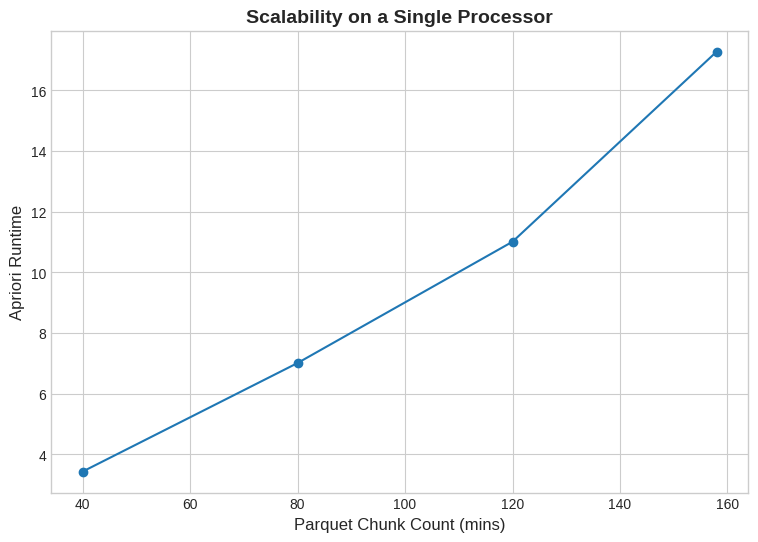

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn

# Data points are 17.28, 11.01, 7.01, 3.43

xpoints = np.array([40, 80, 120, 158])
ypoints = np.array([3.43, 7.01, 11.01, 17.28])

# print(plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(9, 6))
plt.plot(xpoints, ypoints, marker='o')

plt.title('Scalability on a Single Processor', fontsize=14, fontweight='bold')
plt.xlabel('Parquet Chunk Count (mins)', fontsize=12)
plt.ylabel('Apriori Runtime', fontsize=12)

This result shows an inverse relationship between the Parquet chunks and Apriori runtime. As the number of chunks being processed increases, the runtime does too. This is because of the combinatorial count of pairs when running the Apriori algorithm. As well as the size of the dataset. This causes the size to massively increase and blow out of proportion.

Text(0, 0.5, 'Apriori Runtime (mins)')

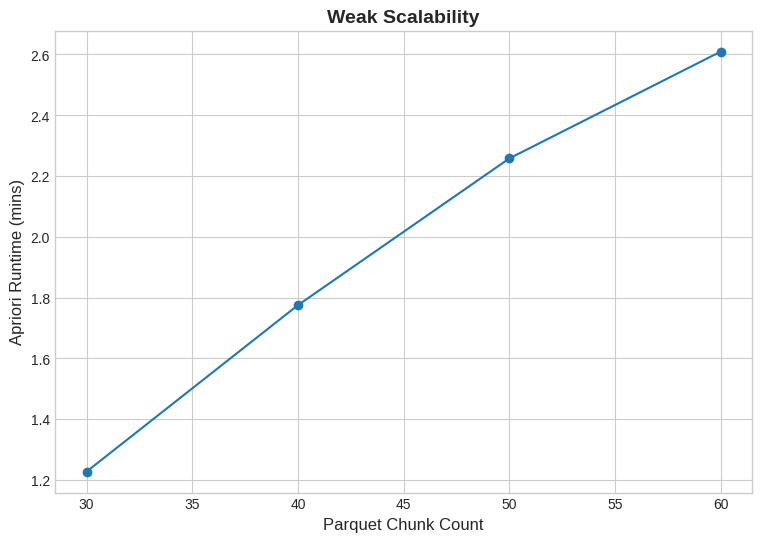

In [ ]:
# Data points are 156.57, 135.48, 106.51, 73.65

xpoints = np.array([30, 40, 50, 60])
ypoints_seconds = np.array([73.65, 106.51, 135.48, 156.57])

ypoints = ypoints_seconds / 60

# print(plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(9, 6))
plt.plot(xpoints, ypoints, marker='o')

plt.title('Weak Scalability', fontsize=14, fontweight='bold')
plt.xlabel('Parquet Chunk Count', fontsize=12)
plt.ylabel('Apriori Runtime (mins)', fontsize=12)

This plot was supposed to show weak scalability but unfortunately it appears similar as the one before it. This plot also shows an inverse relationship between parquet chunk count and the runtime for Apriori. There were difficulties with making the same size data and chunks run on Google Cloud. Every time I ran similar sizes as before, the workers would die. This is regardless of how many different worker settings I would try.

Adjusting the support_n, parquet chunk count and other variables probably caused an incorrect scenario to be able to see weak scalability.